In [ ]:
# setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
import shap, os, json

FIG_DIR = "../figurez/global"; OUT_DIR = "../tables"
os.makedirs(FIG_DIR, exist_ok=True); os.makedirs(OUT_DIR, exist_ok=True)

feature_order = ["MSE ML","iHR V","MSE V","MSE AP","Weigth","Age","Sex (M=1, F=2)","H-Y","Gait Speed","Duration (years)"]
test = pd.read_csv("../data/processed/test_original.csv")
X_test = test[feature_order]; y_test = test["target_bin"].astype(int).values

# carica/ri-addestra RF (come in 04)
rf = RandomForestClassifier(n_estimators=800, min_samples_leaf=3, class_weight="balanced", random_state=42, n_jobs=-1)
train = pd.read_csv("../data/processed/train_balanced_ctgan.csv")
rf.fit(train[feature_order], train["target_bin"].astype(int).values)

p_test = rf.predict_proba(X_test)[:,1]

expl = shap.TreeExplainer(rf, data=train[feature_order], feature_names=feature_order)
shap_expl = expl(X_test)[:,1] if getattr(expl, "model_output", "raw")!="raw" else expl(X_test)

,group,n,AUROC,AUPRC,Brier,Top3_SHAP
0,Sex_M,38,0.761905,0.746576,0.184870,"MSE ML, Weigth, MSE V"
1,Sex_F,11,0.733333,0.861742,0.212987,"iHR V, MSE ML, Sex (M=1, F=2)"
2,Age_ge70,35,0.720000,0.739619,0.206576,"MSE ML, Weigth, Gait Speed"
3,Age_lt70,20,0.747253,0.741270,0.183713,"MSE ML, Weigth, MSE V"


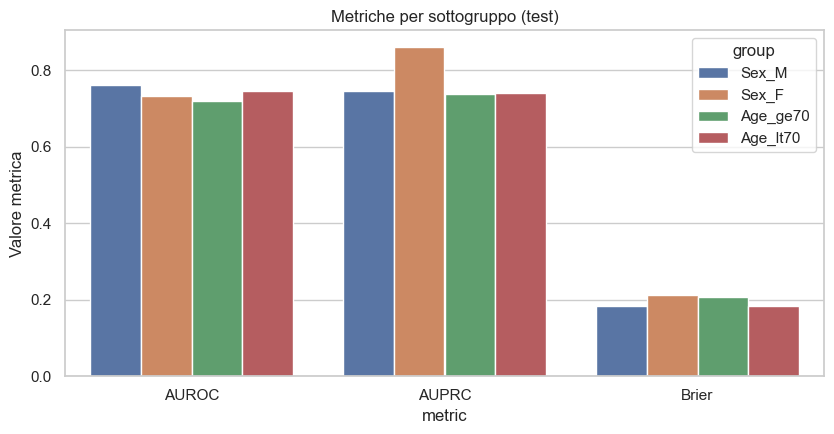

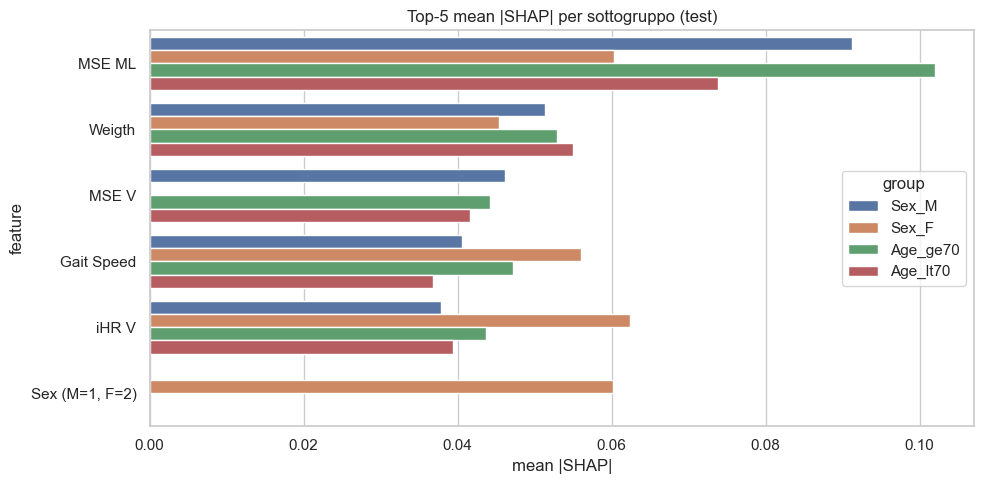

In [ ]:
# =========================
# STEP — Subgroup robustness
# =========================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

sns.set(style="whitegrid")

# --- 1) Helper: estrae matrice SHAP (classe positiva se presenti 2 classi)
def _get_shap_matrix(expl):
    vals = expl.values
    if isinstance(vals, np.ndarray) and vals.ndim == 3:
        # shape tipica: (n_samples, n_features, 2)
        vals = vals[..., 1]   # classe positiva
    return vals  # (n_samples, n_features)

_SHAP_MATRIX = _get_shap_matrix(shap_expl)   # (n_test, n_feat)

# --- 2) Funzione di report per un sottogruppo
def subgroup_report(mask, name):
    mask = np.asarray(mask).astype(bool)
    y = y_test[mask]
    proba = p_test[mask]
    n = int(mask.sum())

    # Metriche robuste (gestione edge-case: una sola classe nel sottogruppo)
    auroc = roc_auc_score(y, proba) if n > 1 and len(np.unique(y)) > 1 else np.nan
    auprc = average_precision_score(y, proba) if n > 0 else np.nan
    brier = brier_score_loss(y, proba) if n > 0 else np.nan

    # mean |SHAP| per feature
    if n > 0:
        sh_mean = np.abs(_SHAP_MATRIX[mask]).mean(axis=0)
    else:
        sh_mean = np.zeros(len(feature_order))
    sh_series = pd.Series(sh_mean, index=feature_order).sort_values(ascending=False)
    top3 = ", ".join(sh_series.index[:3])

    # Calibrazione (decili quantili) salvata su disco per appendice
    if n >= 5:
        nbins = min(10, n)  # evita bin con 1 solo punto
        prob_true, prob_pred = calibration_curve(y, proba, n_bins=nbins, strategy="quantile")
        pd.DataFrame({"pred": prob_pred, "obs": prob_true}).to_csv(
            f"{OUT_DIR}/calib_curve_{name}.csv", index=False
        )

    return {"group": name, "n": n, "AUROC": auroc, "AUPRC": auprc, "Brier": brier, "Top3_SHAP": top3}

# --- 3) Definisci i sottogruppi (modifica/aggiungi a piacere)
subgroups = {
    "Sex_M":   (X_test["Sex (M=1, F=2)"] == 1).values,
    "Sex_F":   (X_test["Sex (M=1, F=2)"] == 2).values,
    "Age_ge70": (X_test["Age"] >= 70).values,
    "Age_lt70": (X_test["Age"] < 70).values,
}

# --- 4) Tabella riassuntiva
sg_tbl = pd.DataFrame([subgroup_report(m, k) for k, m in subgroups.items()])
sg_tbl.to_csv(f"{OUT_DIR}/subgroup_metrics.csv", index=False)
display(sg_tbl)

# --- 5) Figure: bar delle metriche per sottogruppo
_plot = sg_tbl.melt(
    id_vars=["group", "n"],
    value_vars=["AUROC", "AUPRC", "Brier"],
    var_name="metric", value_name="value"
)
plt.figure(figsize=(8.5, 4.5))
sns.barplot(data=_plot, x="metric", y="value", hue="group")
plt.title("Metriche per sottogruppo (test)")
plt.ylabel("Valore metrica")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/subgroup_metrics_bar.png", dpi=300)
plt.show()

# --- 6) Figure: Top-5 mean |SHAP| per sottogruppo
topk = 5
shap_top = []
for name, mask in subgroups.items():
    n = int(np.asarray(mask).sum())
    if n == 0:
        continue
    shm = np.abs(_SHAP_MATRIX[mask]).mean(axis=0)
    df = (
        pd.DataFrame({"feature": feature_order, "mean_abs_shap": shm})
        .sort_values("mean_abs_shap", ascending=False)
        .head(topk)
    )
    df["group"] = name
    shap_top.append(df)

if shap_top:
    shap_top = pd.concat(shap_top, ignore_index=True)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=shap_top, x="mean_abs_shap", y="feature", hue="group")
    plt.xlabel("mean |SHAP|")
    plt.title(f"Top-{topk} mean |SHAP| per sottogruppo (test)")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/subgroup_top{topk}_shap.png", dpi=300)
    plt.show()
else:
    print("Nessun sottogruppo con campioni disponibili per il grafico Top-|SHAP|.")